Imports loaded.
Shapes:
X        : (1011, 37)
y_multi  : (1011, 20)
y_binary : (1011, 1)

Index lengths:
train: 413, valid: 203, test: 395

Split shapes:
X_train: (413, 37) X_valid: (203, 37) X_test: (395, 37)
y_train_multi: (413, 20) y_valid_multi: (203, 20) y_test_multi: (395, 20)
y_train_bin: (413,) y_valid_bin: (203,) y_test_bin: (395,)

Class index → name mapping (multi-class):
0: basal cell carcinoma
1: blue nevus
2: clark nevus
3: combined nevus
4: congenital nevus
5: dermal nevus
6: dermatofibroma
7: lentigo
8: melanoma
9: melanoma (0.76 to 1.5 mm)
10: melanoma (in situ)
11: melanoma (less than 0.76 mm)
12: melanoma (more than 1.5 mm)
13: melanoma metastasis
14: melanosis
15: miscellaneous
16: recurrent nevus
17: reed or spitz nevus
18: seborrheic keratosis
19: vascular lesion

Training set class distribution (index → count):
0      19
1      14
2     176
3       5
4      11
5      19
6       6
7       7
9      21
10     22
11     39
12      6
13      2
14      7
15      3
16  

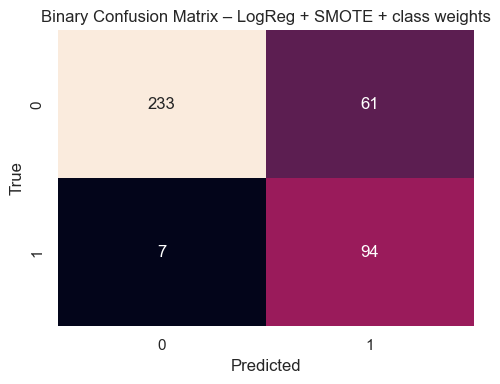

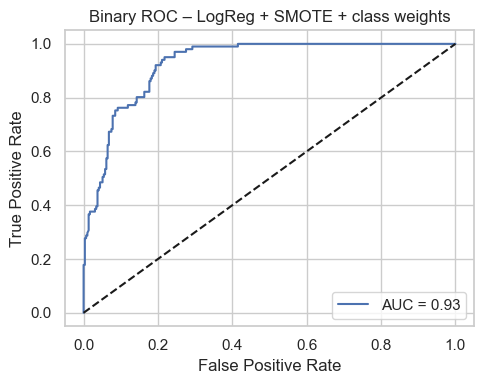


Saving binary predictions for fusion...
Binary prediction files saved:
 - val_binary_predictions.csv
 - test_binary_predictions.csv

Multi-class Baseline – Decision Tree (class-weighted)

Decision Tree – classification report:
                              precision    recall  f1-score   support

        basal cell carcinoma       0.29      0.62      0.40        16
                  blue nevus       0.22      0.18      0.20        11
                 clark nevus       0.86      0.50      0.63       156
              combined nevus       0.00      0.00      0.00         5
            congenital nevus       0.02      0.25      0.04         4
                dermal nevus       0.22      0.50      0.31         8
              dermatofibroma       0.33      0.14      0.20         7
                     lentigo       0.67      0.33      0.44        12
                    melanoma       0.00      0.00      0.00         1
   melanoma (0.76 to 1.5 mm)       0.29      0.28      0.29        18
 

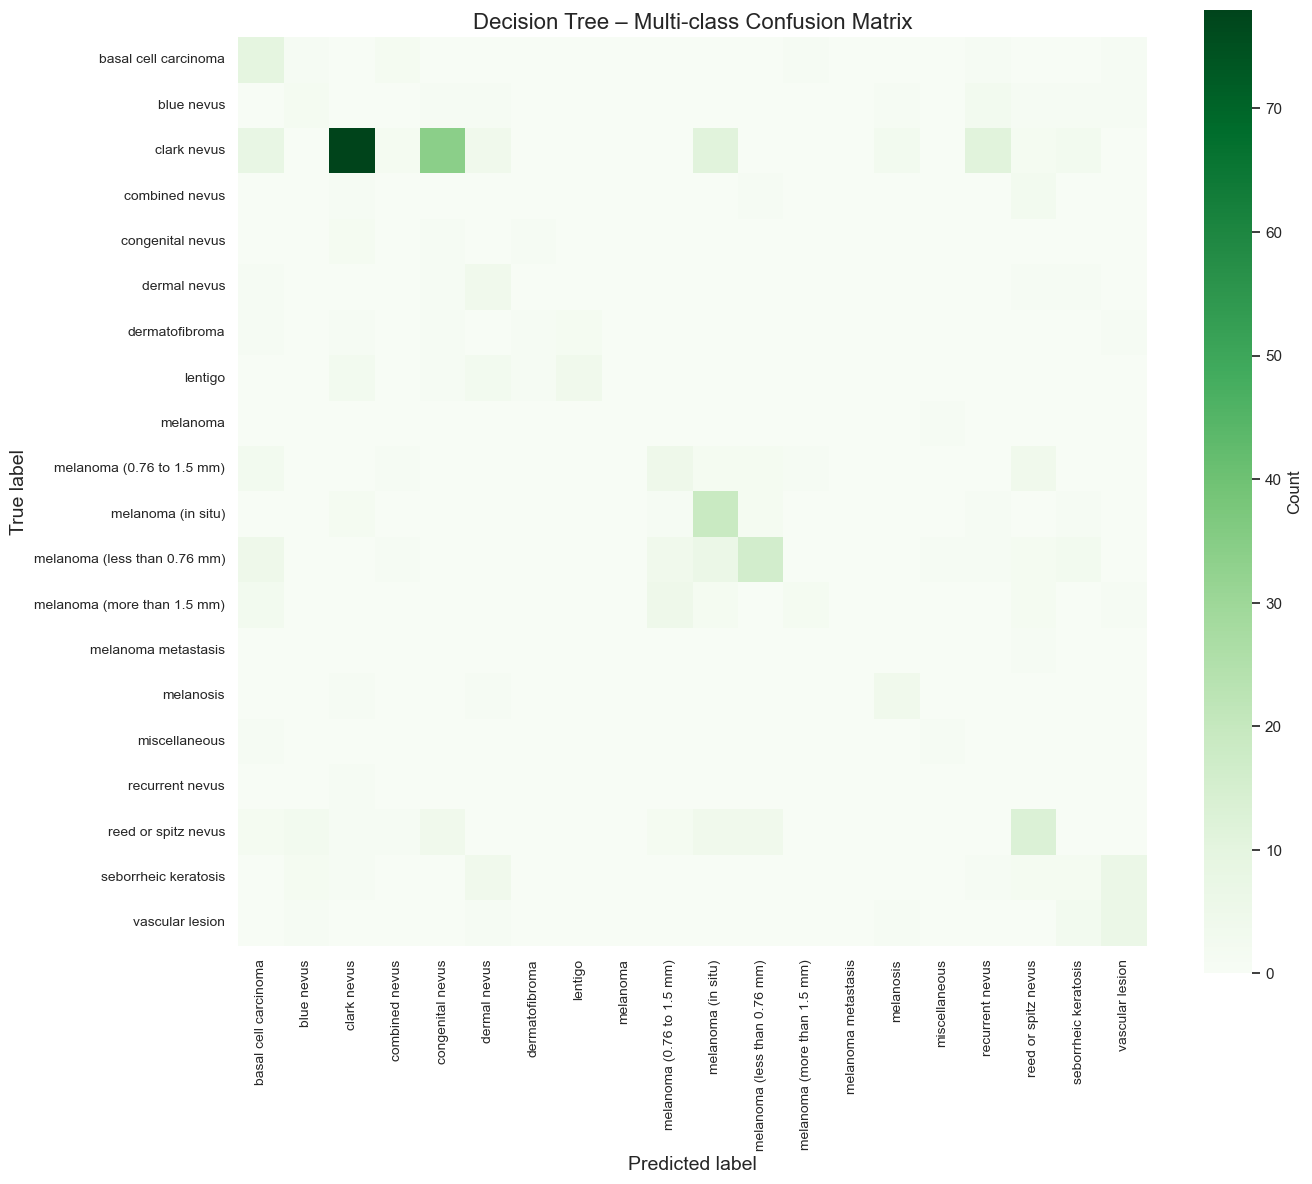


Multi-class – LightGBM (unweighted)
Training until validation scores don't improve for 30 rounds
[50]	train's multi_logloss: 0.507258	valid's multi_logloss: 1.53445
Early stopping, best iteration is:
[42]	train's multi_logloss: 0.599226	valid's multi_logloss: 1.51762

LightGBM (unweighted) – classification report:
                              precision    recall  f1-score   support

        basal cell carcinoma       0.53      0.62      0.57        16
                  blue nevus       0.56      0.45      0.50        11
                 clark nevus       0.72      0.94      0.81       156
              combined nevus       0.00      0.00      0.00         5
            congenital nevus       0.00      0.00      0.00         4
                dermal nevus       0.67      0.50      0.57         8
              dermatofibroma       1.00      0.43      0.60         7
                     lentigo       1.00      0.42      0.59        12
                    melanoma       0.00      0.00   

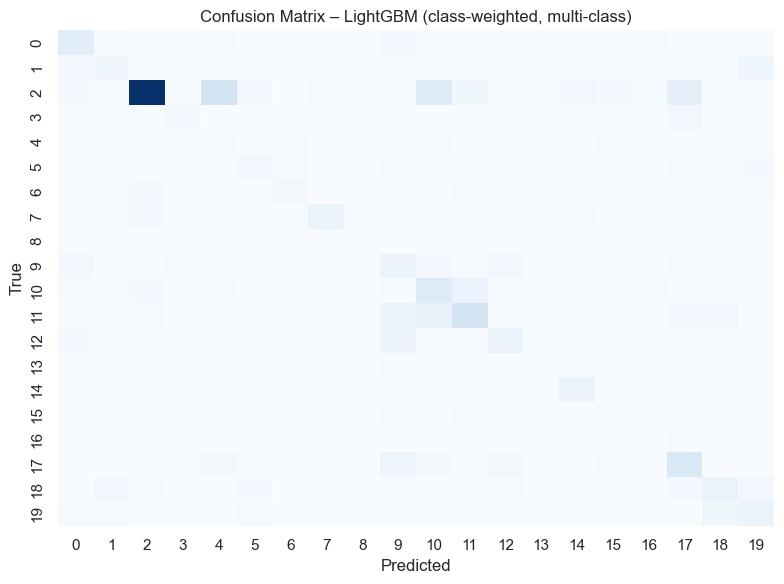


Multi-class – LightGBM (class-weighted) + isotonic calibration


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



LightGBM (class-weighted + calibrated) – classification report:
                              precision    recall  f1-score   support

        basal cell carcinoma       0.69      0.56      0.62        16
                  blue nevus       0.40      0.18      0.25        11
                 clark nevus       0.71      0.93      0.81       156
              combined nevus       0.00      0.00      0.00         5
            congenital nevus       0.00      0.00      0.00         4
                dermal nevus       0.50      0.50      0.50         8
              dermatofibroma       0.40      0.29      0.33         7
                     lentigo       0.43      0.25      0.32        12
                    melanoma       0.00      0.00      0.00         1
   melanoma (0.76 to 1.5 mm)       0.00      0.00      0.00        18
          melanoma (in situ)       0.16      0.31      0.21        26
melanoma (less than 0.76 mm)       0.00      0.00      0.00        40
 melanoma (more than 1.5

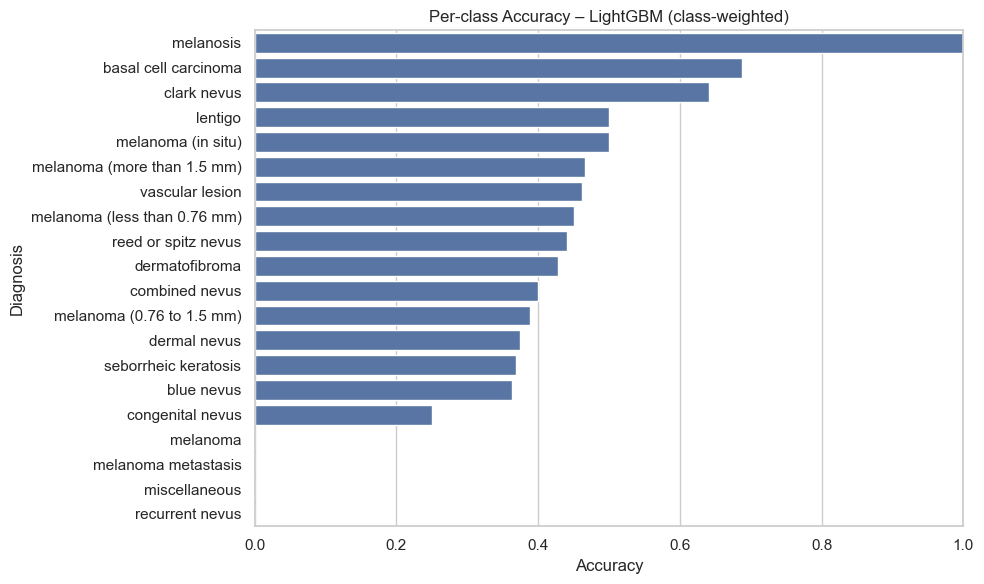


SUMMARY TABLES

Binary Baseline Summary:
                            Model  Accuracy  Precision  Recall      F1     AUC
0  LogReg + SMOTE + class weights    0.8278     0.6065  0.9307  0.7344  0.9277

Multi-class Baseline Summary:
                       Model  Accuracy  Macro F1  Macro AUC
0   Decision Tree (weighted)    0.4278    0.2828     0.6653
1      LightGBM (unweighted)    0.6127    0.3658     0.8967
2  LightGBM (class-weighted)    0.5291    0.3635     0.8989
3      LightGBM (calibrated)    0.4380    0.1518     0.7363
4     Ensemble (DT + LGBM w)    0.4658    0.3027     0.8963


In [3]:
# ======================================================
# ADVANCED TABULAR BASELINES – Derm7pt (Binary + Multi-class)
# Author: Anam Ayyub
# ======================================================
# This notebook:
#  - Loads canonical tabular features and targets
#  - Uses fixed train/valid/test splits from index files
#  - Builds:
#       * Binary baseline (LogReg + SMOTE + class weights)
#       * Multi-class baselines:
#           - Decision Tree (class-weighted)
#           - LightGBM (unweighted)
#           - LightGBM (class-weighted)
#           - LightGBM (class-weighted + isotonic calibration)
#           - Ensemble (Decision Tree + LightGBM weighted)
#  - Prints:
#       * Classification reports
#       * Summary tables (Accuracy, Macro F1, Macro AUC)
#       * Per-class accuracy table
#       * Key plots: confusion matrices, ROC (binary), per-class accuracy bar plot
#
# IMPORTANT:
#  - This code ONLY READS features.csv and targets; it does NOT overwrite any CSV.
#  - No SMOTE on multi-class (extreme rare classes → unstable). We use class weights instead.
#  - SMOTE is used ONLY for the binary baseline on the training set.
# ======================================================

# ======================================================
# Block 1 – Imports
# ======================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    precision_score, recall_score, roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE
import lightgbm as lgb

sns.set(style="whitegrid", context="notebook")
pd.set_option("display.max_columns", 200)

print("Imports loaded.")

# ======================================================
# Block 2 – File paths and loading data
# ======================================================
BASE_DIR = r"C:\Users\anama\Documents\Group_8\Dataset\DERM7PT\meta"

FEATURES_FP       = os.path.join(BASE_DIR, "features.csv")
TARGET_MULTI_FP   = os.path.join(BASE_DIR, "target_multiclass.csv")
TARGET_BIN_FP     = os.path.join(BASE_DIR, "target_binary.csv")
TRAIN_IDX_FP      = os.path.join(BASE_DIR, "train_indexes.csv")
VALID_IDX_FP      = os.path.join(BASE_DIR, "valid_indexes.csv")
TEST_IDX_FP       = os.path.join(BASE_DIR, "test_indexes.csv")

assert os.path.exists(FEATURES_FP), "features.csv not found"
assert os.path.exists(TARGET_MULTI_FP), "target_multiclass.csv not found"
assert os.path.exists(TARGET_BIN_FP), "target_binary.csv not found"

X = pd.read_csv(FEATURES_FP)
y_multi = pd.read_csv(TARGET_MULTI_FP)
y_bin = pd.read_csv(TARGET_BIN_FP)

print("Shapes:")
print("X        :", X.shape)
print("y_multi  :", y_multi.shape)
print("y_binary :", y_bin.shape)


def read_idx(fp):
    """Safe index reader: keeps only integer-like values."""
    df = pd.read_csv(fp)
    col = df.columns[0]
    vals = df[col].tolist()
    clean = []
    for v in vals:
        try:
            clean.append(int(v))
        except Exception:
            continue
    return clean

train_idx = read_idx(TRAIN_IDX_FP)
valid_idx = read_idx(VALID_IDX_FP)
test_idx  = read_idx(TEST_IDX_FP)

print("\nIndex lengths:")
print(f"train: {len(train_idx)}, valid: {len(valid_idx)}, test: {len(test_idx)}")

# Create splits
X_train = X.iloc[train_idx].copy()
X_valid = X.iloc[valid_idx].copy()
X_test  = X.iloc[test_idx].copy()

y_train_multi = y_multi.iloc[train_idx].copy()
y_valid_multi = y_multi.iloc[valid_idx].copy()
y_test_multi  = y_multi.iloc[test_idx].copy()

# For binary, flatten to 1D arrays
y_train_bin = y_bin.iloc[train_idx].values.ravel()
y_valid_bin = y_bin.iloc[valid_idx].values.ravel()
y_test_bin  = y_bin.iloc[test_idx].values.ravel()

print("\nSplit shapes:")
print("X_train:", X_train.shape, "X_valid:", X_valid.shape, "X_test:", X_test.shape)
print("y_train_multi:", y_train_multi.shape, "y_valid_multi:", y_valid_multi.shape, "y_test_multi:", y_test_multi.shape)
print("y_train_bin:", y_train_bin.shape, "y_valid_bin:", y_valid_bin.shape, "y_test_bin:", y_test_bin.shape)

# ======================================================
# Block 3 – Class index → name mapping (multi-class)
# ======================================================
class_names = list(y_multi.columns)
print("\nClass index → name mapping (multi-class):")
for idx, name in enumerate(class_names):
    print(f"{idx}: {name}")

# Prepare label vectors for multi-class
y_train_labels = y_train_multi.values.argmax(axis=1)
y_valid_labels = y_valid_multi.values.argmax(axis=1)
y_test_labels  = y_test_multi.values.argmax(axis=1)

# Show train distribution
train_counts = pd.Series(y_train_labels).value_counts().sort_index()
print("\nTraining set class distribution (index → count):")
print(train_counts)

# ======================================================
# Block 4 – Preprocessing
#   - Tree models: original numeric + categoricals (category dtype)
#   - Logistic Regression (binary): one-hot + StandardScaler + SMOTE
# ======================================================

# 4.1 – Data for tree-based models (LightGBM + Decision Tree)
X_train_tree = X_train.copy()
X_valid_tree = X_valid.copy()
X_test_tree  = X_test.copy()

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
for col in cat_cols:
    X_train_tree[col] = X_train_tree[col].astype("category")
    X_valid_tree[col] = X_valid_tree[col].astype("category")
    X_test_tree[col]  = X_test_tree[col].astype("category")

print("\nTree-based preprocessing complete.")
print("Categorical columns:", cat_cols)

# 4.2 – Data for Logistic Regression (binary): one-hot + scaling
X_encoded = pd.get_dummies(X, drop_first=True)
X_train_lr = X_encoded.iloc[train_idx].copy()
X_valid_lr = X_encoded.iloc[valid_idx].copy()
X_test_lr  = X_encoded.iloc[test_idx].copy()

num_cols_lr = X_train_lr.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train_lr[num_cols_lr] = scaler.fit_transform(X_train_lr[num_cols_lr])
X_valid_lr[num_cols_lr] = scaler.transform(X_valid_lr[num_cols_lr])
X_test_lr[num_cols_lr]  = scaler.transform(X_test_lr[num_cols_lr])

print("\nLogistic Regression preprocessing complete.")
print("Encoded feature shape:", X_encoded.shape)

# 4.3 – SMOTE for binary training ONLY (safe k_neighbors for very small minority)
sm = SMOTE(random_state=42, k_neighbors=1)
X_train_lr_sm, y_train_bin_sm = sm.fit_resample(X_train_lr, y_train_bin)

print("\nBinary SMOTE applied on training set only.")
print("Original binary train size :", X_train_lr.shape[0])
print("Resampled binary train size:", X_train_lr_sm.shape[0])

# ======================================================
# Block 5 – Compute class weights (binary + multi-class)
# ======================================================
# Multi-class
classes_multi = np.unique(y_train_labels)
weights_multi = compute_class_weight(
    class_weight="balanced",
    classes=classes_multi,
    y=y_train_labels
)
class_weight_multi = {cls: w for cls, w in zip(classes_multi, weights_multi)}

print("\nComputed multi-class class weights (index: weight):")
for cls, w in class_weight_multi.items():
    print(f"{cls} ({class_names[cls]}): {w:.3f}")

# Binary
classes_bin = np.unique(y_train_bin)
weights_bin = compute_class_weight(
    class_weight="balanced",
    classes=classes_bin,
    y=y_train_bin
)
class_weight_bin = {int(cls): float(w) for cls, w in zip(classes_bin, weights_bin)}

print("\nComputed binary class weights (label: weight):")
for cls, w in class_weight_bin.items():
    print(f"{cls}: {w:.3f}")

# ======================================================
# Block 6 – Binary baseline: Logistic Regression + SMOTE + class weights
# ======================================================
print("\n" + "="*60)
print("Binary Baseline – Logistic Regression + SMOTE + class weights")
print("="*60)

log_reg_bin = LogisticRegression(
    max_iter=1000,
    class_weight=class_weight_bin,
    solver="liblinear",
    random_state=42
)

log_reg_bin.fit(X_train_lr_sm, y_train_bin_sm)

y_pred_bin = log_reg_bin.predict(X_test_lr)
y_proba_bin = log_reg_bin.predict_proba(X_test_lr)[:, 1]

print("\nBinary classification report (Logistic Regression):")
print(classification_report(y_test_bin, y_pred_bin, zero_division=0))

bin_acc = accuracy_score(y_test_bin, y_pred_bin)
bin_prec = precision_score(y_test_bin, y_pred_bin, zero_division=0)
bin_rec = recall_score(y_test_bin, y_pred_bin, zero_division=0)
bin_f1 = f1_score(y_test_bin, y_pred_bin, zero_division=0)
bin_auc = roc_auc_score(y_test_bin, y_proba_bin)

print("Binary metrics:")
print(f"Accuracy : {bin_acc:.4f}")
print(f"Precision: {bin_prec:.4f}")
print(f"Recall   : {bin_rec:.4f}")
print(f"F1-score : {bin_f1:.4f}")
print(f"AUC      : {bin_auc:.4f}")

# ---- Binary confusion matrix plot ----
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_bin, annot=True, fmt="d", cbar=False)
plt.title("Binary Confusion Matrix – LogReg + SMOTE + class weights")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ---- Binary ROC curve ----
fpr, tpr, _ = roc_curve(y_test_bin, y_proba_bin)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {bin_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Binary ROC – LogReg + SMOTE + class weights")
plt.legend()
plt.tight_layout()
plt.show()
# ======================================================
# Block 6B – Save Binary Predictions (Validation + Test)
#   Required later for fusion / stacking
# ======================================================

print("\nSaving binary predictions for fusion...")

SAVE_DIR = BASE_DIR  # same folder where features.csv is stored

# ---- 1) Validation predictions ----
val_pred_bin  = log_reg_bin.predict(X_valid_lr)
val_proba_bin = log_reg_bin.predict_proba(X_valid_lr)[:, 1]

df_val_bin = pd.DataFrame({
    "true_label": y_valid_bin,
    "pred_label": val_pred_bin,
    "proba_1": val_proba_bin
})
df_val_bin.to_csv(os.path.join(SAVE_DIR, "val_binary_predictions.csv"), index=False)


# ---- 2) Test predictions ----
test_pred_bin  = log_reg_bin.predict(X_test_lr)
test_proba_bin = log_reg_bin.predict_proba(X_test_lr)[:, 1]

df_test_bin = pd.DataFrame({
    "true_label": y_test_bin,
    "pred_label": test_pred_bin,
    "proba_1": test_proba_bin
})
df_test_bin.to_csv(os.path.join(SAVE_DIR, "test_binary_predictions.csv"), index=False)

print("Binary prediction files saved:")
print(" - val_binary_predictions.csv")
print(" - test_binary_predictions.csv")


# ======================================================
# Block 7 – Multi-class: Decision Tree (class-weighted)
# ======================================================
print("\n" + "="*60)
print("Multi-class Baseline – Decision Tree (class-weighted)")
print("="*60)

dt = DecisionTreeClassifier(
    max_depth=8,
    random_state=42,
    class_weight="balanced"
)
dt.fit(X_train_tree, y_train_labels)

y_pred_dt = dt.predict(X_test_tree)
y_proba_dt_raw = dt.predict_proba(X_test_tree)   # shape: (n_samples, n_dt_classes)

print("\nDecision Tree – classification report:")
print(classification_report(y_test_labels, y_pred_dt, target_names=class_names, zero_division=0))

# Build full probability matrix for all classes (for AUC & ensemble)
num_classes = y_train_multi.shape[1]
proba_dt_full = np.zeros((len(y_test_labels), num_classes))
dt_classes = dt.classes_  # indices of classes seen by the tree

for i, cls in enumerate(dt_classes):
    proba_dt_full[:, cls] = y_proba_dt_raw[:, i]

dt_acc = accuracy_score(y_test_labels, y_pred_dt)
dt_f1  = f1_score(y_test_labels, y_pred_dt, average="macro")

try:
    dt_auc = roc_auc_score(y_test_multi, proba_dt_full, multi_class="ovr")
except ValueError:
    dt_auc = np.nan

print("Decision Tree metrics:")
print(f"Accuracy : {dt_acc:.4f}")
print(f"Macro F1 : {dt_f1:.4f}")
print(f"Macro AUC: {dt_auc:.4f}")
# ======================================================
# Block X — Decision Tree (class-weighted) Confusion Matrix (Green Palette)
# ======================================================

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm_dt = confusion_matrix(y_test_labels, y_pred_dt)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_dt,
    annot=False,
    cmap="Greens",          # <<< Green palette
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={"label": "Count"},
    square=True
)

plt.title("Decision Tree – Multi-class Confusion Matrix", fontsize=16)
plt.xlabel("Predicted label", fontsize=14)
plt.ylabel("True label", fontsize=14)

plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

# ======================================================
# Block 8 – Multi-class: LightGBM (unweighted)
# ======================================================
print("\n" + "="*60)
print("Multi-class – LightGBM (unweighted)")
print("="*60)

num_classes = y_train_multi.shape[1]

params_base = {
    "objective": "multiclass",
    "num_class": num_classes,
    "metric": "multi_logloss",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "verbosity": -1,
    "seed": 42
}

train_data_base = lgb.Dataset(X_train_tree, label=y_train_labels)
valid_data_base = lgb.Dataset(X_valid_tree, label=y_valid_labels)

model_lgb_base = lgb.train(
    params_base,
    train_data_base,
    valid_sets=[train_data_base, valid_data_base],
    valid_names=["train", "valid"],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=50)
    ]
)

y_proba_lgb_base = model_lgb_base.predict(X_test_tree)
y_pred_lgb_base = np.argmax(y_proba_lgb_base, axis=1)

print("\nLightGBM (unweighted) – classification report:")
print(classification_report(y_test_labels, y_pred_lgb_base, target_names=class_names, zero_division=0))

lgb_base_acc = accuracy_score(y_test_labels, y_pred_lgb_base)
lgb_base_f1  = f1_score(y_test_labels, y_pred_lgb_base, average="macro")
try:
    lgb_base_auc = roc_auc_score(y_test_multi, y_proba_lgb_base, multi_class="ovr")
except ValueError:
    lgb_base_auc = np.nan

print("LightGBM (unweighted) metrics:")
print(f"Accuracy : {lgb_base_acc:.4f}")
print(f"Macro F1 : {lgb_base_f1:.4f}")
print(f"Macro AUC: {lgb_base_auc:.4f}")

# ======================================================
# Block 9 – Multi-class: LightGBM (class-weighted, inverse-frequency)
# ======================================================
print("\n" + "="*60)
print("Multi-class – LightGBM (class-weighted)")
print("="*60)

# Per-sample weights from class_weight_multi
sample_weight_train = np.array([class_weight_multi[c] for c in y_train_labels])

params_weighted = params_base.copy()

train_data_w = lgb.Dataset(X_train_tree, label=y_train_labels, weight=sample_weight_train)
valid_data_w = lgb.Dataset(X_valid_tree, label=y_valid_labels)

model_lgb_w = lgb.train(
    params_weighted,
    train_data_w,
    valid_sets=[train_data_w, valid_data_w],
    valid_names=["train", "valid"],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=50)
    ]
)

y_proba_lgb_w = model_lgb_w.predict(X_test_tree)
y_pred_lgb_w = np.argmax(y_proba_lgb_w, axis=1)

print("\nLightGBM (class-weighted) – classification report:")
print(classification_report(y_test_labels, y_pred_lgb_w, target_names=class_names, zero_division=0))

lgb_w_acc = accuracy_score(y_test_labels, y_pred_lgb_w)
lgb_w_f1  = f1_score(y_test_labels, y_pred_lgb_w, average="macro")
try:
    lgb_w_auc = roc_auc_score(y_test_multi, y_proba_lgb_w, multi_class="ovr")
except ValueError:
    lgb_w_auc = np.nan

print("LightGBM (class-weighted) metrics:")
print(f"Accuracy : {lgb_w_acc:.4f}")
print(f"Macro F1 : {lgb_w_f1:.4f}")
print(f"Macro AUC: {lgb_w_auc:.4f}")

# ---- Multi-class confusion matrix for LightGBM (class-weighted) ----
cm_lgb_w = confusion_matrix(y_test_labels, y_pred_lgb_w)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgb_w, cmap="Blues", cbar=False)
plt.title("Confusion Matrix – LightGBM (class-weighted, multi-class)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# ======================================================
# Block 10 – Multi-class: LightGBM (class-weighted) + isotonic calibration
# ======================================================
print("\n" + "="*60)
print("Multi-class – LightGBM (class-weighted) + isotonic calibration")
print("="*60)

# Train a LightGBM classifier with class_weight dict
lgb_clf = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=num_classes,
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=500,
    random_state=42,
    class_weight=class_weight_multi
)

# ---- Step 1: Fit LGBM on training data ----
lgb_clf.fit(X_train_tree, y_train_labels)

# ---- Step 2: Calibrate using validation set ----
calib = CalibratedClassifierCV(
    estimator=lgb_clf,
    method="isotonic",
    cv="prefit"      # ⚠ Will show a harmless sklearn warning — IGNORE
)

calib.fit(X_valid_tree, y_valid_labels)

# ---- Step 3: Calibrated predictions on test ----
y_proba_lgb_cal = calib.predict_proba(X_test_tree)
y_pred_lgb_cal = np.argmax(y_proba_lgb_cal, axis=1)

print("\nLightGBM (class-weighted + calibrated) – classification report:")
print(classification_report(
    y_test_labels,
    y_pred_lgb_cal,
    target_names=class_names,
    zero_division=0
))

lgb_cal_acc = accuracy_score(y_test_labels, y_pred_lgb_cal)
lgb_cal_f1  = f1_score(y_test_labels, y_pred_lgb_cal, average="macro")

try:
    lgb_cal_auc = roc_auc_score(y_test_multi, y_proba_lgb_cal, multi_class="ovr")
except ValueError:
    lgb_cal_auc = np.nan

print("LightGBM (calibrated) metrics:")
print(f"Accuracy : {lgb_cal_acc:.4f}")
print(f"Macro F1 : {lgb_cal_f1:.4f}")
print(f"Macro AUC: {lgb_cal_auc:.4f}")


# ======================================================
# Block 11 – Multi-class Ensemble (Decision Tree + LightGBM weighted)
# ======================================================
print("\n" + "="*60)
print("Multi-class – Ensemble (Decision Tree + LightGBM weighted)")
print("="*60)

# proba_dt_full: already (n_samples × num_classes) from Block 7
proba_dt = proba_dt_full
proba_lgb = y_proba_lgb_w  # already full matrix (n_samples × num_classes)

# Weighted average ensemble
proba_ens = 0.5 * proba_dt + 0.5 * proba_lgb
y_pred_ens = np.argmax(proba_ens, axis=1)

print("\nEnsemble – classification report:")
print(classification_report(
    y_test_labels, y_pred_ens, target_names=class_names, zero_division=0
))

ens_acc = accuracy_score(y_test_labels, y_pred_ens)
ens_f1  = f1_score(y_test_labels, y_pred_ens, average="macro")

try:
    ens_auc = roc_auc_score(y_test_multi, proba_ens, multi_class="ovr")
except ValueError:
    ens_auc = np.nan

print("Ensemble metrics:")
print(f"Accuracy : {ens_acc:.4f}")
print(f"Macro F1 : {ens_f1:.4f}")
print(f"Macro AUC: {ens_auc:.4f}")

# ======================================================
# Block 12 – Per-class accuracy for LightGBM (class-weighted)
# ======================================================
print("\n" + "="*60)
print("Per-class accuracy – LightGBM (class-weighted)")
print("="*60)

per_class_acc = []
for idx, name in enumerate(class_names):
    mask = (y_test_labels == idx)
    if mask.sum() == 0:
        acc = np.nan
    else:
        acc = np.mean(y_pred_lgb_w[mask] == idx)
    per_class_acc.append((name, acc))

acc_df = pd.DataFrame(per_class_acc, columns=["Diagnosis", "Accuracy"]).sort_values(
    by="Accuracy", ascending=False
)

print("Per-class accuracy table:")
print(acc_df.round(3))

plt.figure(figsize=(10, 6))
sns.barplot(data=acc_df, x="Accuracy", y="Diagnosis")
plt.title("Per-class Accuracy – LightGBM (class-weighted)")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# ======================================================
# Block 13 – Summary tables (Binary + Multi-class)
# ======================================================
print("\n" + "="*60)
print("SUMMARY TABLES")
print("="*60)

# Binary summary
binary_summary = pd.DataFrame(
    {
        "Model": ["LogReg + SMOTE + class weights"],
        "Accuracy": [bin_acc],
        "Precision": [bin_prec],
        "Recall": [bin_rec],
        "F1": [bin_f1],
        "AUC": [bin_auc],
    }
)

print("\nBinary Baseline Summary:")
print(binary_summary.round(4))

# Multi-class summary
multi_summary = pd.DataFrame(
    [
        ["Decision Tree (weighted)", dt_acc,  dt_f1,  dt_auc],
        ["LightGBM (unweighted)",    lgb_base_acc, lgb_base_f1, lgb_base_auc],
        ["LightGBM (class-weighted)",lgb_w_acc,   lgb_w_f1,   lgb_w_auc],
        ["LightGBM (calibrated)",    lgb_cal_acc, lgb_cal_f1, lgb_cal_auc],
        ["Ensemble (DT + LGBM w)",   ens_acc,     ens_f1,     ens_auc],
    ],
    columns=["Model", "Accuracy", "Macro F1", "Macro AUC"]
)

print("\nMulti-class Baseline Summary:")
print(multi_summary.round(4))


In [2]:
# ======================================================
# Block 14 – Save Validation Predictions for Fusion
# ======================================================

print("\n" + "="*60)
print("Saving Validation Predictions for Fusion")
print("="*60)

SAVE_DIR = BASE_DIR   # same meta folder

# -------------------------
# 1) Binary: Logistic Regression
# -------------------------
val_pred_bin  = log_reg_bin.predict(X_valid_lr)
val_proba_bin = log_reg_bin.predict_proba(X_valid_lr)[:, 1]

df_bin = pd.DataFrame({
    "true_label": y_valid_bin,
    "pred_label": val_pred_bin,
    "proba_1": val_proba_bin
})

df_bin.to_csv(os.path.join(SAVE_DIR, "binary_validation_predictions.csv"), index=False)
print("✓ Saved: binary_validation_predictions.csv")

# -------------------------
# 2) Multiclass: LightGBM (class-weighted)
# -------------------------
val_proba_lgb = model_lgb_w.predict(X_valid_tree)
val_pred_lgb  = np.argmax(val_proba_lgb, axis=1)

# Save all 20-class probabilities
df_mc = pd.DataFrame(val_proba_lgb, columns=[f"proba_{c}" for c in class_names])
df_mc.insert(0, "true_label", y_valid_labels)
df_mc.insert(1, "pred_label", val_pred_lgb)

df_mc.to_csv(os.path.join(SAVE_DIR, "multiclass_validation_predictions.csv"), index=False)
print("✓ Saved: multiclass_validation_predictions.csv")

print("\nAll validation predictions successfully saved.")



Saving Validation Predictions for Fusion


NameError: name 'BASE_DIR' is not defined


WEIGHTED METRICS FOR MULTI-CLASS MODELS

[1] LightGBM (Unweighted)
Weighted Precision: 0.6072
Weighted Recall   : 0.6127
Weighted F1       : 0.5871


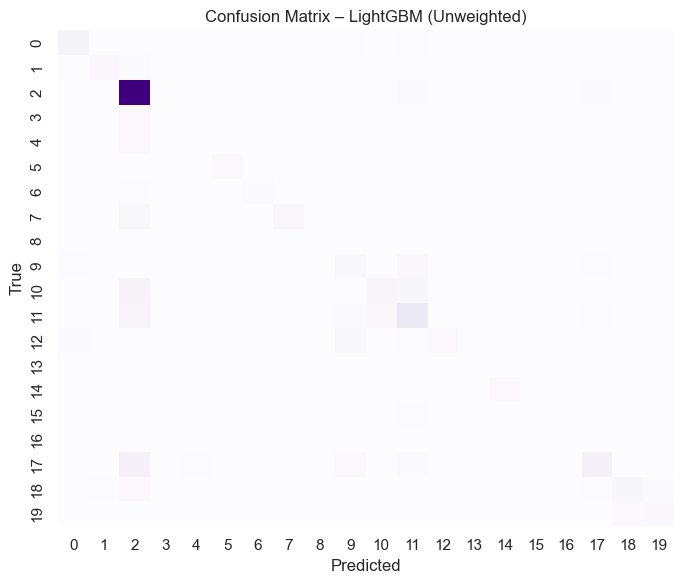


[2] LightGBM (Class-weighted)
Weighted Precision: 0.6231
Weighted Recall   : 0.5291
Weighted F1       : 0.5602


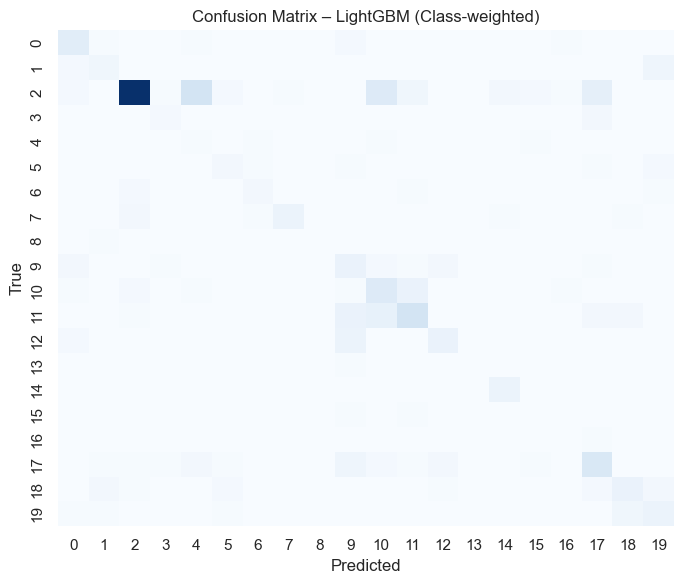


[3] Ensemble (DT + LGBM weighted)
Weighted Precision: 0.5930
Weighted Recall   : 0.4658
Weighted F1       : 0.4998


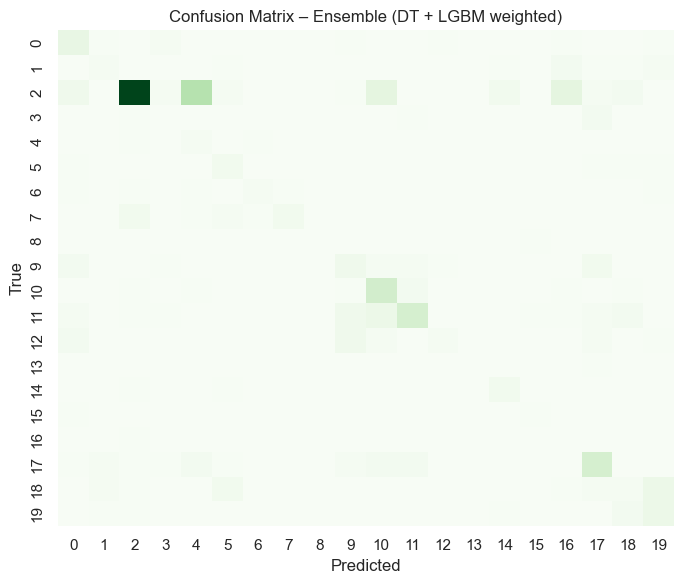

In [4]:
# ======================================================
# SAFE RELOAD OF REQUIRED VARIABLES
# (Handles kernel restarts)
# ======================================================

# y_test_labels
try:
    y_test_labels
except NameError:
    y_test_labels = y_test_multi.values.argmax(axis=1)

# LightGBM unweighted predictions
try:
    y_pred_lgb_base
except NameError:
    y_pred_lgb_base = np.argmax(model_lgb_base.predict(X_test_tree), axis=1)

# LightGBM class-weighted predictions
try:
    y_pred_lgb_w
except NameError:
    y_pred_lgb_w = np.argmax(model_lgb_w.predict(X_test_tree), axis=1)

# Ensemble predictions
try:
    y_pred_ens
except NameError:
    proba_dt = proba_dt_full
    proba_lgb = model_lgb_w.predict(X_test_tree)
    proba_ens = 0.5 * proba_dt + 0.5 * proba_lgb
    y_pred_ens = np.argmax(proba_ens, axis=1)



# ======================================================
# EXTRA METRICS — Weighted F1, Precision, Recall, CM
# ======================================================
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix
)

print("\n" + "="*70)
print("WEIGHTED METRICS FOR MULTI-CLASS MODELS")
print("="*70)


# ------------------------------------------------------
# LightGBM (unweighted)
# ------------------------------------------------------
print("\n[1] LightGBM (Unweighted)")

lgb_unw_precision_w = precision_score(y_test_labels, y_pred_lgb_base, average="weighted", zero_division=0)
lgb_unw_recall_w    = recall_score(y_test_labels, y_pred_lgb_base, average="weighted", zero_division=0)
lgb_unw_f1_w        = f1_score(y_test_labels, y_pred_lgb_base, average="weighted", zero_division=0)

print(f"Weighted Precision: {lgb_unw_precision_w:.4f}")
print(f"Weighted Recall   : {lgb_unw_recall_w:.4f}")
print(f"Weighted F1       : {lgb_unw_f1_w:.4f}")

cm_lgb_unw = confusion_matrix(y_test_labels, y_pred_lgb_base)
plt.figure(figsize=(7,6))
sns.heatmap(cm_lgb_unw, cmap="Purples", cbar=False)
plt.title("Confusion Matrix – LightGBM (Unweighted)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()



# ------------------------------------------------------
# LightGBM (Class-weighted)
# ------------------------------------------------------
print("\n[2] LightGBM (Class-weighted)")

lgb_w_precision_w = precision_score(y_test_labels, y_pred_lgb_w, average="weighted", zero_division=0)
lgb_w_recall_w    = recall_score(y_test_labels, y_pred_lgb_w, average="weighted", zero_division=0)
lgb_w_f1_w        = f1_score(y_test_labels, y_pred_lgb_w, average="weighted", zero_division=0)

print(f"Weighted Precision: {lgb_w_precision_w:.4f}")
print(f"Weighted Recall   : {lgb_w_recall_w:.4f}")
print(f"Weighted F1       : {lgb_w_f1_w:.4f}")

cm_lgb_w2 = confusion_matrix(y_test_labels, y_pred_lgb_w)
plt.figure(figsize=(7,6))
sns.heatmap(cm_lgb_w2, cmap="Blues", cbar=False)
plt.title("Confusion Matrix – LightGBM (Class-weighted)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()



# ------------------------------------------------------
# Ensemble (Decision Tree + LGBM weighted)
# ------------------------------------------------------
print("\n[3] Ensemble (DT + LGBM weighted)")

ens_precision_w = precision_score(y_test_labels, y_pred_ens, average="weighted", zero_division=0)
ens_recall_w    = recall_score(y_test_labels, y_pred_ens, average="weighted", zero_division=0)
ens_f1_w        = f1_score(y_test_labels, y_pred_ens, average="weighted", zero_division=0)

print(f"Weighted Precision: {ens_precision_w:.4f}")
print(f"Weighted Recall   : {ens_recall_w:.4f}")
print(f"Weighted F1       : {ens_f1_w:.4f}")

cm_ens = confusion_matrix(y_test_labels, y_pred_ens)
plt.figure(figsize=(7,6))
sns.heatmap(cm_ens, cmap="Greens", cbar=False)
plt.title("Confusion Matrix – Ensemble (DT + LGBM weighted)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()
